In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy import stats
from math import sqrt

In [2]:
def parse_boat_results(boat_res_file):
    
    num_lines = sum(1 for line in open(boat_res_file))
    
    boat_result = np.zeros([num_lines, 3])
    
    with open(boat_res_file) as boat_f:
        for line_cnt, line in enumerate(boat_f):
            for el_cnt, arr_el in enumerate(line.strip().split(",")):
                if el_cnt < 3:
                    boat_result[line_cnt, el_cnt] = float(arr_el.split("=")[1])
    
    return boat_result

def find_best_solution(xmins, target_lms):
    closest_dist = np.inf
    closest_point = None
    
    for xmin in xmins:
        for bh_lm in target_lms:

            dist = np.linalg.norm(xmin - bh_lm)
            if dist < closest_dist: 
                closest_dist = dist
                closest_point = xmin
                
    return closest_point, closest_dist

In [3]:
def analyse_performance(points):
    
    no_tests = len(points)
    no_steps = len(points[no_tests-1])
    perform_stats = np.zeros([no_steps, 5], dtype=np.float32)
    
    for i in range(no_steps):
        dist_arr = np.zeros(no_tests, dtype=np.float32)
   
        for j in range(no_tests):
            point = np.array([points[j][i][0], points[j][i][1]])
            
            dist = find_best_solution([point], branin_hoo_lms)
            dist_arr[j] = dist[1]
        
        dist_stats = stats.describe(dist_arr)
                
        perform_stats[i][0] = i
        perform_stats[i][1] = dist_stats.mean
        perform_stats[i][2] = sqrt(dist_stats.variance)
        perform_stats[i][3] = dist_stats.minmax[0]
        perform_stats[i][4] = dist_stats.minmax[1]
        
#         if i == 0:
#             perform_stats[i][5] = perform_stats[i][3]
#         else:

#             perform_stats[i][5] = min(perform_stats[i-1][5], perform_stats[i][3])
            
    return perform_stats

In [4]:
def best_so_far_analysis(points):
    
    no_tests = len(points)
    no_steps = len(points[no_tests-1])    
    
    best_so_far = np.zeros([no_steps, no_tests], dtype=np.float32)
    best_so_far_stats = np.zeros([no_steps, 5], dtype=np.float32)
    
    for i in range(no_steps):
        dist_arr = np.zeros(no_tests, dtype=np.float32)

        for j in range(no_tests):
            point = np.array([points[j][i][0], points[j][i][1]])
            dist = find_best_solution([point], branin_hoo_lms)[1]
            
            if i == 0:
                best_so_far[i][j] = dist
            else:
                best_so_far[i][j] = min(best_so_far[i-1][j], dist)
        
        
        best_stats = stats.describe(best_so_far[i][:])
        
        best_so_far_stats[i][0] = i
        best_so_far_stats[i][1] = best_stats.mean
        best_so_far_stats[i][2] = sqrt(best_stats.variance)
        best_so_far_stats[i][3] = best_stats.minmax[0]
        best_so_far_stats[i][4] = best_stats.minmax[1]
        
    return best_so_far_stats

## Branin-Hoo minima

In [5]:
branin_hoo_lms = np.stack(
    (np.array([-math.pi, math.pi, 9.42478]), 
     np.array([12.275, 2.275, 2.475]))).transpose()

## BOAT results

In [6]:
boat_res_files = glob.glob("boat_results/struct_*.out")

boat_results = []

for boat_res_file in boat_res_files:
    boat_results.append(parse_boat_results(boat_res_file))

boat_perf_stats_sbo = analyse_performance(boat_results)

## Pyro results

Using 10 simulations and 20 first steps from them.

In [7]:
pkl_file = open('sbo_15_results.pkl', 'rb')
results_bo_full = pickle.load(pkl_file)
pkl_file.close()

pyro_results = []
for sim_i in range(5, results_bo_full.shape[-1]): 
    pyro_results.append(results_bo_full[:20,:,sim_i])
    
pyro_perf_stats_sbo = analyse_performance(pyro_results)

## Plotting BOAT

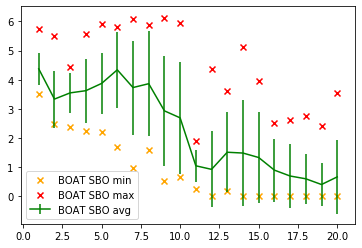

In [8]:
plt.figure()

plt.scatter(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 3], 
            color='orange', marker='x', label='BOAT SBO min')

plt.scatter(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 4], 
            color='r', marker='x', label='BOAT SBO max')

plt.errorbar(boat_perf_stats_sbo[:, 0]+1, boat_perf_stats_sbo[:, 1], 
             boat_perf_stats_sbo[:, 2], color='g', label='BOAT SBO avg')

plt.legend();

## Plotting Pyro

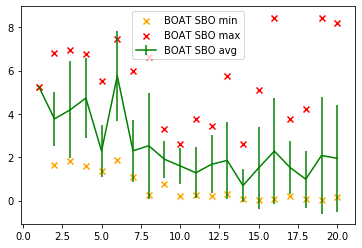

In [9]:
plt.figure()

plt.scatter(pyro_perf_stats_sbo[:, 0]+1, pyro_perf_stats_sbo[:, 3], 
            color='orange', marker='x', label='BOAT SBO min')

plt.scatter(pyro_perf_stats_sbo[:, 0]+1, pyro_perf_stats_sbo[:, 4], 
            color='r', marker='x', label='BOAT SBO max')

plt.errorbar(pyro_perf_stats_sbo[:, 0]+1, pyro_perf_stats_sbo[:, 1], 
             pyro_perf_stats_sbo[:, 2], color='g', label='BOAT SBO avg')


plt.legend();

## Plotting comparison

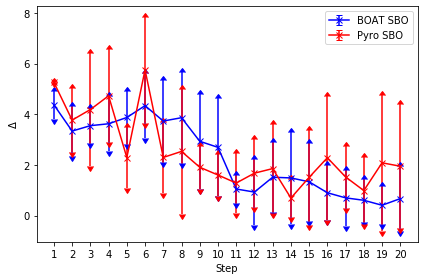

In [10]:
x = np.arange(min(len(boat_perf_stats_sbo[:, 0]), len(pyro_perf_stats_sbo[:, 0]))) + 1

plt.figure()

plt.errorbar(x, boat_perf_stats_sbo[:len(x), 1], 
             boat_perf_stats_sbo[:len(x), 2], color='blue', label='BOAT SBO', 
             marker="x", uplims=True, lolims=True)

plt.errorbar(x, pyro_perf_stats_sbo[:len(x), 1], 
             pyro_perf_stats_sbo[:len(x)+1, 2], color='red', label='Pyro SBO', 
             marker="x", uplims=True, lolims=True)

plt.xticks(x)
plt.xlabel('Step')
plt.ylabel('$\Delta$')
plt.tight_layout()
plt.legend();

plt.savefig('bh_pyro_boat_compr_avg.png', dpi=300)

In [11]:
pyro_best_results = best_so_far_analysis(pyro_results)
boat_best_results = best_so_far_analysis(boat_results)

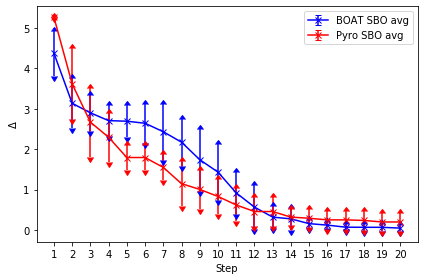

In [14]:
plt.figure()

plt.errorbar(boat_best_results[:, 0]+1, boat_best_results[:, 1], 
             boat_best_results[:, 2], color='blue', label='BOAT SBO avg',
             marker="x", uplims=True, lolims=True)

plt.errorbar(pyro_best_results[:, 0]+1, pyro_best_results[:, 1], 
             pyro_best_results[:, 2], color='red', label='Pyro SBO avg',
             marker="x", uplims=True, lolims=True)


plt.xticks(x)
plt.xlabel('Step')
plt.ylabel('$\Delta$')
plt.tight_layout()
plt.legend();

plt.savefig('bh_pyro_boat_compr_best.png', dpi=300)